In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
print(torch.__version__)
print(torch.cuda.is_available())

1.6.0
True


# 1. Dataset

In [2]:
from sklearn.datasets import load_breast_cancer

data = load_breast_cancer()
data.keys()

dict_keys(['data', 'target', 'target_names', 'DESCR', 'feature_names', 'filename'])

#### data

In [3]:
# data['data']
df = pd.DataFrame.from_dict(data['data'])

display(df.shape)
display(df.head())

(569, 30)

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [4]:
display(data['feature_names'].shape)
display(data['feature_names'])

(30,)

array(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error',
       'fractal dimension error', 'worst radius', 'worst texture',
       'worst perimeter', 'worst area', 'worst smoothness',
       'worst compactness', 'worst concavity', 'worst concave points',
       'worst symmetry', 'worst fractal dimension'], dtype='<U23')

#### targets

In [5]:
# data['target']
display(data['target'].shape)
display(data['target'][:100])

(569,)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0,
       1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0,
       1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0])

In [6]:
# data['target_names']
display(data['target_names'].shape)
display(data['target_names'])

(2,)

array(['malignant', 'benign'], dtype='<U9')

## 1.1 Train-test split

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data.data, data.target, test_size=0.33)

## 1.2 Data scaling

In [8]:
print(X_train.mean(), X_train.std())

63.39878846590551 236.10629646869413


In [9]:
from sklearn.preprocessing import StandardScaler

# mean = 0, std = 1 
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [10]:
print(X_train.mean(), X_train.std())

-3.3071630395833186e-16 1.0


## 1.3 Convert to torch tensor

In [11]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(381, 30) (381,)
(188, 30) (188,)


In [12]:
X_train = torch.from_numpy(X_train.astype(np.float32))
X_test = torch.from_numpy(X_test.astype(np.float32))
y_train = torch.from_numpy(y_train.astype(np.float32).reshape(-1, 1))
y_test = torch.from_numpy(y_test.astype(np.float32).reshape(-1, 1))

In [13]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([381, 30]) torch.Size([381, 1])
torch.Size([188, 30]) torch.Size([188, 1])


# 2. Model
## 2.1 Sequential model

In [14]:
N, D = X_train.shape

# model
import torch.nn as nn
lr_model = nn.Sequential(
    nn.Linear(D, 1),
    nn.Sigmoid()
)

# Loss
bce_loss = nn.BCEWithLogitsLoss()

# optimizer
adam_opt = torch.optim.Adam(lr_model.parameters())

#### Train

In [15]:
def fit(X_train, y_train, X_valid, y_valid, model, loss_fn, optimizer, n_epochs):
    train_losses = np.zeros(n_epochs)
    valid_losses = np.zeros(n_epochs)
    for i in range(n_epochs):
        # zero the parameter gradients
        optimizer.zero_grad()

        # Forward
        y_train_ = model(X_train)
        loss = loss_fn(y_train_, y_train)

        # Backward
        loss.backward()
        optimizer.step()

        # Get valid loss
        y_valid_ = model(X_valid)
        loss_val = loss_fn(y_valid_, y_valid)

        # Save losses
        train_losses[i] = loss.item()
        valid_losses[i] = loss_val.item()

        if (i+1)%100==0: print(f"Epoch {i+1}/{n_epochs}, Train Loss: {loss.item():.4f}, Valid Loss: {loss_val.item():.4f}")

    # Plot losses
    plt.plot(train_losses, label='train loss')
    plt.plot(valid_losses, label='valid loss')
    plt.legend()
    plt.show()

Epoch 100/1000, Train Loss: 0.5647, Valid Loss: 0.5538
Epoch 200/1000, Train Loss: 0.5308, Valid Loss: 0.5227
Epoch 300/1000, Train Loss: 0.5160, Valid Loss: 0.5087
Epoch 400/1000, Train Loss: 0.5074, Valid Loss: 0.5003
Epoch 500/1000, Train Loss: 0.5016, Valid Loss: 0.4945
Epoch 600/1000, Train Loss: 0.4973, Valid Loss: 0.4902
Epoch 700/1000, Train Loss: 0.4939, Valid Loss: 0.4868
Epoch 800/1000, Train Loss: 0.4911, Valid Loss: 0.4839
Epoch 900/1000, Train Loss: 0.4884, Valid Loss: 0.4813
Epoch 1000/1000, Train Loss: 0.4864, Valid Loss: 0.4795


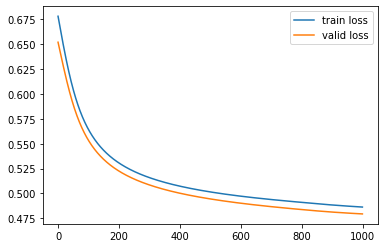

In [16]:
X_valid = X_test
y_valid = y_test 

fit(
    X_train, y_train,
    X_valid, y_valid,
    model=lr_model, loss_fn=bce_loss, optimizer=adam_opt,
    n_epochs=1000)

#### Test

In [17]:
# Get accuracy
with torch.no_grad():
    y_test_ = lr_model(X_test)

    y_test_ = np.round(y_test_.numpy())
    test_acc = np.mean(y_test.numpy() == y_test_)
    print(f"Test acc: {test_acc:.4f}")

Test acc: 0.9628


## 2.2 Logistic Regression model

In [18]:
N, D = X_train.shape

# model
import torch.nn as nn
lr_model = nn.Linear(D, 1)

# Loss
bce_loss = nn.BCEWithLogitsLoss()

# optimizer
adam_opt = torch.optim.Adam(lr_model.parameters())

#### Train

Epoch 100/1000, Train Loss: 0.2954, Valid Loss: 0.3331
Epoch 200/1000, Train Loss: 0.2036, Valid Loss: 0.2373
Epoch 300/1000, Train Loss: 0.1602, Valid Loss: 0.1937
Epoch 400/1000, Train Loss: 0.1349, Valid Loss: 0.1694
Epoch 500/1000, Train Loss: 0.1182, Valid Loss: 0.1541
Epoch 600/1000, Train Loss: 0.1060, Valid Loss: 0.1438
Epoch 700/1000, Train Loss: 0.0968, Valid Loss: 0.1364
Epoch 800/1000, Train Loss: 0.0894, Valid Loss: 0.1311
Epoch 900/1000, Train Loss: 0.0833, Valid Loss: 0.1270
Epoch 1000/1000, Train Loss: 0.0782, Valid Loss: 0.1240


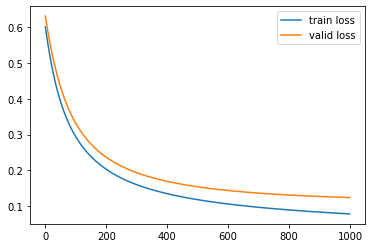

In [19]:
X_valid = X_test
y_valid = y_test 

fit(
    X_train, y_train,
    X_valid, y_valid,
    model=lr_model, loss_fn=bce_loss, optimizer=adam_opt,
    n_epochs=1000)

#### Test

In [20]:
# Get accuracy
with torch.no_grad():
    y_test_ = lr_model(X_test)
    y_test_ = (y_test_.numpy() > 0)
    test_acc = np.mean(y_test.numpy() == y_test_)
    print(f"Test acc: {test_acc:.4f}")

Test acc: 0.9574
